In [1]:
%reset

import os
import sys

# Very hacky, bad thing to do.
SRC_PATH = os.path.realpath('../src')
sys.path.append(SRC_PATH)

from defaults import SAMPLE_RATE
from synthesis import synth_out
import IPython.display as ipd

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
Reading VC_mV_sus_f_C3.wav...
WORLD analysis...
Detected 10 peaks. Choosing peak 4.


In [2]:
y = synth_out[0]['wav']
ipd.Audio(y, rate=SAMPLE_RATE) 

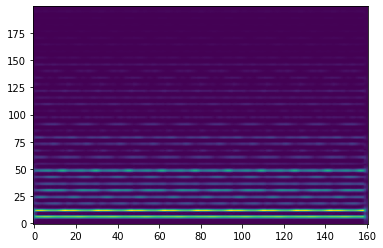

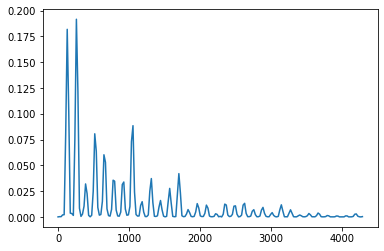

In [5]:
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt

stft_ = stft(y, fs=SAMPLE_RATE, nperseg=2048, noverlap=2048-512)[2]
spectrogram = np.abs(stft_)

plt.imshow(spectrogram[:200, :], origin='lower', aspect='auto')
plt.show()

f_ = np.arange(2048 // 2) / 2048 * SAMPLE_RATE

plt.plot(f_[:200], spectrogram[:200, 3])
plt.show()